In [181]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,OneHotEncoder, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss

from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report

In [126]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [127]:
train.head(5)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [128]:
train.shape

(26457, 20)

In [129]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

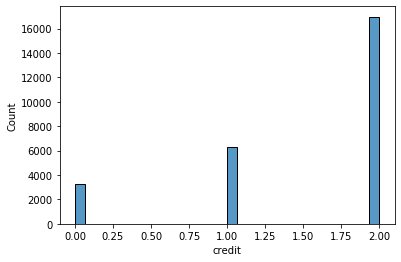

In [130]:
sns.histplot(train.credit)

([<matplotlib.patches.Wedge at 0x7fcc2d199b10>,
 [Text(-0.4725510999727826, 0.9933254541762802, '2.0'),
  Text(0.06755226441625439, -1.0979238095479287, '1.0'),
  Text(1.0204705316112848, -0.41065787964311823, '0.0')],
 [Text(-0.2577551454396996, 0.5418138840961527, '64.1%'),
  Text(0.0368466896815933, -0.5988675324806884, '23.7%'),
  Text(0.5566202899697916, -0.22399520707806447, '12.2%')])

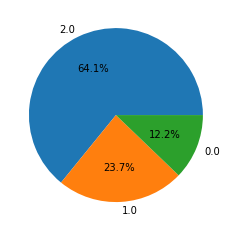

In [131]:
plt.pie(train.credit.value_counts(),autopct="%1.1f%%",labels=train.credit.value_counts().keys() )

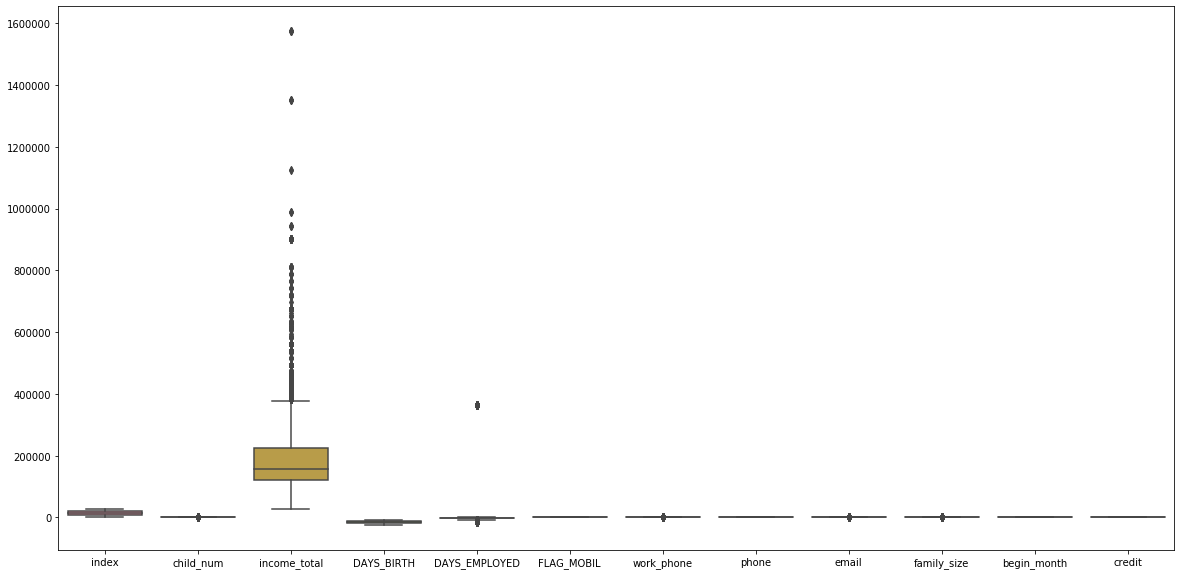

In [132]:
plt.figure(figsize=(20,10), facecolor='w')
sns.boxplot(data=train)
plt.show()

### DAYS_EMPLOYED feature

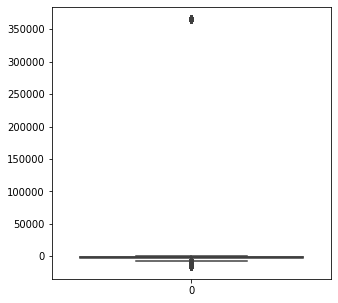

In [133]:
plt.figure(figsize=(5,5), facecolor='w')
sns.boxplot(data=train.DAYS_EMPLOYED)
plt.show()

In [134]:
train[train.DAYS_EMPLOYED>=0].DAYS_EMPLOYED

14       365243
18       365243
21       365243
24       365243
46       365243
          ...  
26431    365243
26432    365243
26439    365243
26441    365243
26443    365243
Name: DAYS_EMPLOYED, Length: 4438, dtype: int64

In [135]:
train[train.DAYS_EMPLOYED>=0].DAYS_EMPLOYED.unique()

array([365243])

In [136]:
train[train.DAYS_EMPLOYED>=0].occyp_type.unique()

array([nan], dtype=object)

- 고용된 날짜가 양수인 경우 현재 무직으로 볼 수 있지만 모든 데이터가 365243으로 100년 이상이다.
- 또한 고용 날짜가 양수인 모든 고용타입이 NaN으로 되어있다.
- 365243은 너무 큰 수이므로 0으로 변환해 준다.

In [137]:
train.DAYS_EMPLOYED = train.DAYS_EMPLOYED.map(lambda x: 0 if x > 0 else x)

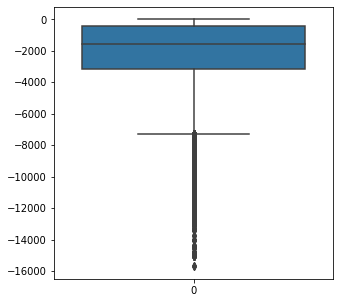

In [138]:
plt.figure(figsize=(5,5), facecolor='w')
sns.boxplot(data=train.DAYS_EMPLOYED)
plt.show()

In [139]:
train[train.DAYS_EMPLOYED>0].DAYS_EMPLOYED

Series([], Name: DAYS_EMPLOYED, dtype: int64)

### FLAG_MOBIL feature

In [140]:
train.FLAG_MOBIL.unique()

array([1])

- FLAG_MOBIL 은 모두 1을 가지고 있으므로 삭제

In [141]:
train.drop(['FLAG_MOBIL'], axis=1, inplace=True)

In [142]:
train.duplicated().sum()

0

In [143]:
train.shape

(26457, 19)

### family_size feature

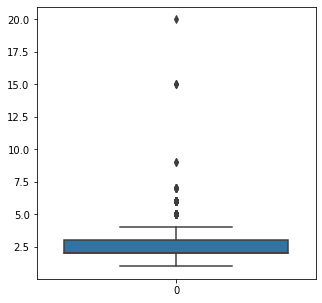

In [144]:
plt.figure(figsize=(5,5), facecolor='w')
sns.boxplot(data=[train.family_size])
plt.show()

In [145]:
sorted(train.family_size, reverse=True)[:15]

[20.0, 15.0, 15.0, 15.0, 9.0, 9.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]

- 가족 규모가 20명인 경우가 있을 수 있지만 대부분 7 이하인 것을 확인할 수 있다.
- 7이상인 데이터는 이상치로 판단하고 지워준다.

In [146]:
train = train[train.family_size<8]

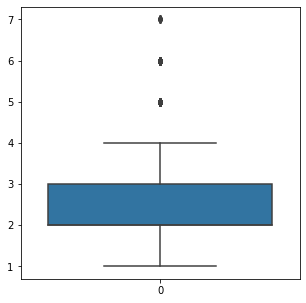

In [147]:
plt.figure(figsize=(5,5), facecolor='w')
sns.boxplot(data=[train.family_size])
plt.show()

In [148]:
train.shape

(26451, 19)

### child_num featrue

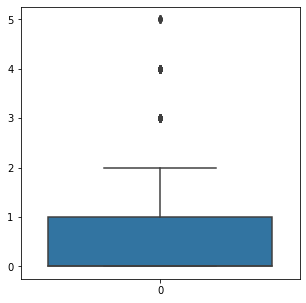

In [149]:
plt.figure(figsize=(5,5), facecolor='w')
sns.boxplot(data=[train.child_num])
plt.show()

In [150]:
train[(train.family_size-train.child_num)<0]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
14900,14900,M,Y,N,2,225000.0,Working,Secondary / secondary special,Married,House / apartment,-14776,-2212,0,0,0,Drivers,1.0,-30.0,2.0


- 가족 규모에서 자녀수를 뺐을 때 음수가 나올 수 없다고 판단. 한가지 케이스뿐 이지만 이를 삭제해 준다.

In [151]:
train = train[(train.family_size-train.child_num)>=0]

In [152]:
train.shape

(26450, 19)

#### NaN 값 판별

In [153]:
train.isna().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

- 직업 유형(occy_type)에 NaN값이 존재한다.
- 따라서 직업 유형이 NaN인 경우 무직이므로 이를 문자열 'NaN'으로 대체한다.
- index 열은 삭제해 준다.

In [154]:
train.fillna('NaN', inplace=True)
train.drop(['index'], axis=1, inplace=True)

In [155]:
train.isna().sum()

gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
dtype: int64

In [156]:
train.shape

(26450, 18)

## Numerical and Categorical Features

- 수치형 데이터와 목록형 데이터 구별

In [157]:
train.dtypes

gender            object
car               object
reality           object
child_num          int64
income_total     float64
income_type       object
edu_type          object
family_type       object
house_type        object
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
work_phone         int64
phone              int64
email              int64
occyp_type        object
family_size      float64
begin_month      float64
credit           float64
dtype: object

In [158]:
cate_feature = train.columns[train.dtypes==object].tolist()
cate_feature

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type']

In [159]:
num_feature = train.columns[train.dtypes!=object].tolist()
num_feature

['child_num',
 'income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'credit']

### Numeric data 전처리

In [160]:
train[num_feature].head(5)

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,202500.0,-13899,-4709,0,0,0,2.0,-6.0,1.0
1,1,247500.0,-11380,-1540,0,0,1,3.0,-5.0,1.0
2,0,450000.0,-19087,-4434,0,1,0,2.0,-22.0,2.0
3,0,202500.0,-15088,-2092,0,1,0,2.0,-37.0,0.0
4,0,157500.0,-15037,-2105,0,0,0,2.0,-26.0,2.0


- DAYS_BIRTH --> Age(양수) 나이로 변환
- DAYS_EMPLOYED --> 근속일자는 년차(양수)로 변환
- begin_month --> 신용카드 사용월 수는 양수로 변환

In [161]:
train.DAYS_BIRTH = train.DAYS_BIRTH//365*(-1)
train.rename(columns = {'DAYS_BIRTH' : 'AGE'}, inplace = True)
num_feature[num_feature.index('DAYS_BIRTH')] = "AGE"

train.DAYS_EMPLOYED = train.DAYS_EMPLOYED//365*(-1)
train.begin_month = train.begin_month*(-1)

In [162]:
train[num_feature].head(5)

,child_num,income_total,AGE,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,202500.0,39,13,0,0,0,2.0,6.0,1.0
1,1,247500.0,32,5,0,0,1,3.0,5.0,1.0
2,0,450000.0,53,13,0,1,0,2.0,22.0,2.0
3,0,202500.0,42,6,0,1,0,2.0,37.0,0.0
4,0,157500.0,42,6,0,0,0,2.0,26.0,2.0


### Categorical data 전처리
> OrdinalEncoder

In [163]:
encoder = OrdinalEncoder()
train[cate_feature] = encoder.fit_transform(train[cate_feature])

In [164]:
train.head(5)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,AGE,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0.0,0.0,0.0,0,202500.0,0.0,1.0,1.0,2.0,39,13,0,0,0,12.0,2.0,6.0,1.0
1,0.0,0.0,1.0,1,247500.0,0.0,4.0,0.0,1.0,32,5,0,0,1,8.0,3.0,5.0,1.0
2,1.0,1.0,1.0,0,450000.0,4.0,1.0,1.0,1.0,53,13,0,1,0,10.0,2.0,22.0,2.0
3,0.0,0.0,1.0,0,202500.0,0.0,4.0,1.0,1.0,42,6,0,1,0,15.0,2.0,37.0,0.0
4,0.0,1.0,1.0,0,157500.0,2.0,1.0,1.0,1.0,42,6,0,0,0,10.0,2.0,26.0,2.0


### KMEANS 알고리즘으로 클러스터링한 feature데이터 열을 추가

In [165]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=15, random_state=1).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)

In [166]:
train.head(5)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,AGE,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,cluster
0,0.0,0.0,0.0,0,202500.0,0.0,1.0,1.0,2.0,39,13,0,0,0,12.0,2.0,6.0,1.0,3
1,0.0,0.0,1.0,1,247500.0,0.0,4.0,0.0,1.0,32,5,0,0,1,8.0,3.0,5.0,1.0,11
2,1.0,1.0,1.0,0,450000.0,4.0,1.0,1.0,1.0,53,13,0,1,0,10.0,2.0,22.0,2.0,9
3,0.0,0.0,1.0,0,202500.0,0.0,4.0,1.0,1.0,42,6,0,1,0,15.0,2.0,37.0,0.0,3
4,0.0,1.0,1.0,0,157500.0,2.0,1.0,1.0,1.0,42,6,0,0,0,10.0,2.0,26.0,2.0,8


### Numerical features scailing
> log scailing : income_total의 경우 높은 정수값을 가지고 있어 log스케일로 변환해 준다.    
> StandardScaler : 대부분의 이상치를 제거했다고 판단하여 사용에 문제가 없다고 판단했다.

In [167]:
train.income_total = np.log1p(train.income_total)
num_feature.remove('income_total')

In [168]:
ss = StandardScaler()
train[num_feature[:-1]] = ss.fit_transform(train[num_feature[:-1]])

In [169]:
train.head(5)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,AGE,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,cluster
0,0.0,0.0,0.0,-0.589809,12.218500,0.0,1.0,1.0,2.0,-0.452674,0.996514,-0.538334,-0.645649,-0.316983,12.0,-0.216315,-1.215211,1.0,3
1,0.0,0.0,1.0,0.795174,12.419170,0.0,4.0,0.0,1.0,-1.060664,-0.218915,-0.538334,-0.645649,3.154739,8.0,0.897257,-1.275601,1.0,11
2,1.0,1.0,1.0,-0.589809,13.017005,4.0,1.0,1.0,1.0,0.763306,0.996514,-0.538334,1.548828,-0.316983,10.0,-0.216315,-0.248968,2.0,9
3,0.0,0.0,1.0,-0.589809,12.218500,0.0,4.0,1.0,1.0,-0.192107,-0.066986,-0.538334,1.548828,-0.316983,15.0,-0.216315,0.656886,0.0,3
4,0.0,1.0,1.0,-0.589809,11.967187,2.0,1.0,1.0,1.0,-0.192107,-0.066986,-0.538334,-0.645649,-0.316983,10.0,-0.216315,-0.007407,2.0,8


## 데이터 분할

In [170]:
y = train.credit
X = train.drop(['credit'],axis=1)

In [171]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1 )

In [172]:
train.head(5)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,AGE,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,cluster
0,0.0,0.0,0.0,-0.589809,12.218500,0.0,1.0,1.0,2.0,-0.452674,0.996514,-0.538334,-0.645649,-0.316983,12.0,-0.216315,-1.215211,1.0,3
1,0.0,0.0,1.0,0.795174,12.419170,0.0,4.0,0.0,1.0,-1.060664,-0.218915,-0.538334,-0.645649,3.154739,8.0,0.897257,-1.275601,1.0,11
2,1.0,1.0,1.0,-0.589809,13.017005,4.0,1.0,1.0,1.0,0.763306,0.996514,-0.538334,1.548828,-0.316983,10.0,-0.216315,-0.248968,2.0,9
3,0.0,0.0,1.0,-0.589809,12.218500,0.0,4.0,1.0,1.0,-0.192107,-0.066986,-0.538334,1.548828,-0.316983,15.0,-0.216315,0.656886,0.0,3
4,0.0,1.0,1.0,-0.589809,11.967187,2.0,1.0,1.0,1.0,-0.192107,-0.066986,-0.538334,-0.645649,-0.316983,10.0,-0.216315,-0.007407,2.0,8


## Random Forest

In [173]:
rf = RandomForestClassifier()
rf.fit(train_x, train_y)

RandomForestClassifier()

In [174]:
log_loss(test_y, rf.predict_proba(test_x))

0.8558059372330598

## Catboost

In [175]:
# test_data = Pool(data=test_x, label=test_y)
model = CatBoostClassifier()
model.fit(train_x, train_y,use_best_model=True, early_stopping_rounds=100, verbose=100)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.091826
0:	learn: 1.0484470	total: 12.6ms	remaining: 12.6s
100:	learn: 0.7749283	total: 601ms	remaining: 5.35s
200:	learn: 0.7401799	total: 1.2s	remaining: 4.79s
300:	learn: 0.7102544	total: 1.79s	remaining: 4.15s
400:	learn: 0.6844174	total: 2.39s	remaining: 3.58s
500:	learn: 0.6621956	total: 3.05s	remaining: 3.04s
600:	learn: 0.6415372	total: 3.71s	remaining: 2.46s
700:	learn: 0.6233729	total: 4.34s	remaining: 1.85s
800:	learn: 0.6072743	total: 4.96s	remaining: 1.23s
900:	learn: 0.5921270	total: 5.66s	remaining: 622ms
999:	learn: 0.5778569	total: 6.29s	remaining: 0us


In [176]:
log_loss(test_y, model.predict_proba(test_x))

0.7471924528689772

- Catboost 모델이 더 좋은 결과를 보인 것을 확인.

## stratifiedkFold
- 교차검증을 하기위한 방법.
- kfold의 경우 split시에 학습데이터와 검증데이터의 불균형이 생길 우려가 있으므로 이를 극복하기위해 레이블의 분포를 동일하게 가져가는 방법.

In [177]:
train = train.reset_index(drop=True)
y = train.credit
X = train.drop(['credit'],axis=1)

stkfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
fold_list = list()
model_list = list()
logloss_list = list()

for train_idx, test_idx in stkfold.split(X,y):
    print("-"*10+" CrossValidation "+"-"*10)
    train_x = X.iloc[train_idx]
    train_y = y[train_idx]
    
    test_x = X.iloc[test_idx]
    test_y = y[test_idx]
    
    test_set = Pool(data=test_x, label=test_y)
    
    
    model = CatBoostClassifier()
    model.fit(train_x, train_y,eval_set=test_set,use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    ll = log_loss(test_y, model.predict_proba(test_x))

    
    logloss_list.append(ll)
    model_list.append(model)
    print(f" logloss : {ll}")

---------- CrossValidation ----------
Learning rate set to 0.115043
0:	learn: 1.0356043	test: 1.0356707	best: 1.0356707 (0)	total: 8.3ms	remaining: 8.3s
100:	learn: 0.7659963	test: 0.7912435	best: 0.7912435 (100)	total: 896ms	remaining: 7.97s
200:	learn: 0.7304886	test: 0.7783876	best: 0.7783876 (200)	total: 1.63s	remaining: 6.49s
300:	learn: 0.7007166	test: 0.7681292	best: 0.7681292 (300)	total: 2.4s	remaining: 5.58s
400:	learn: 0.6754727	test: 0.7610100	best: 0.7610100 (400)	total: 3.28s	remaining: 4.9s
500:	learn: 0.6517334	test: 0.7554017	best: 0.7553451 (492)	total: 4s	remaining: 3.98s
600:	learn: 0.6305146	test: 0.7508512	best: 0.7508512 (600)	total: 4.78s	remaining: 3.17s
700:	learn: 0.6127959	test: 0.7468453	best: 0.7467999 (696)	total: 5.51s	remaining: 2.35s
800:	learn: 0.5965768	test: 0.7446570	best: 0.7446462 (795)	total: 6.31s	remaining: 1.57s
900:	learn: 0.5813928	test: 0.7426064	best: 0.7423873 (897)	total: 7.1s	remaining: 781ms
999:	learn: 0.5680863	test: 0.7411969	best:

100:	learn: 0.7664729	test: 0.7872015	best: 0.7872015 (100)	total: 673ms	remaining: 5.99s
200:	learn: 0.7286807	test: 0.7718533	best: 0.7718533 (200)	total: 1.35s	remaining: 5.36s
300:	learn: 0.6959202	test: 0.7641211	best: 0.7639861 (298)	total: 2.03s	remaining: 4.72s
400:	learn: 0.6709745	test: 0.7587868	best: 0.7587868 (400)	total: 2.71s	remaining: 4.05s
500:	learn: 0.6488822	test: 0.7555138	best: 0.7551105 (489)	total: 3.39s	remaining: 3.38s
600:	learn: 0.6276869	test: 0.7525463	best: 0.7525463 (600)	total: 4.07s	remaining: 2.71s
700:	learn: 0.6101000	test: 0.7508473	best: 0.7508078 (699)	total: 4.75s	remaining: 2.03s
800:	learn: 0.5925885	test: 0.7497280	best: 0.7496578 (797)	total: 5.44s	remaining: 1.35s
900:	learn: 0.5771076	test: 0.7489266	best: 0.7488992 (899)	total: 6.16s	remaining: 677ms
999:	learn: 0.5636292	test: 0.7491821	best: 0.7488992 (899)	total: 6.89s	remaining: 0us

bestTest = 0.7488991989
bestIteration = 899

Shrink model to first 900 iterations.
 logloss : 0.74889

In [178]:
best_idx = logloss_list.index(min(logloss_list))
best_model = model_list[best_idx]
print(logloss_list[best_idx])

0.7204759464228229


In [182]:
model = best_model

## Feature Importance

In [123]:
model.feature_importances_

array([ 2.26396471,  3.0065195 ,  2.67114529,  2.06562906, 10.35325708,
        3.94468359,  4.32498729,  4.21071218,  1.84848495, 13.05109451,
       10.01364604,  2.36444713,  2.95092161,  1.14675688,  8.43555583,
        2.44699316, 17.40388213,  7.49731906])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


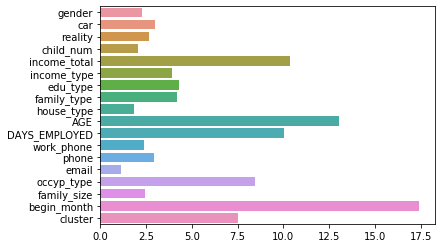

In [124]:
sns.barplot(model.feature_importances_, model.feature_names_)